In [1]:
# Подключение библиотек ## Загрузить при запуске предобученной сети
import numpy as np 
import cv2 as cv 
import matplotlib.pyplot as plt 
from PIL import Image 
import torch 
from torch import nn, optim 
from torch.utils.data import Dataset 
from torchvision import datasets 
import torchvision.transforms as transforms 
from typing import Type, Union 
from IPython.display import clear_output, display 
from ipywidgets import Output 
from tqdm.auto import trange 
from numpy.random import randint 
import os 
import zipfile 
from torch.utils.data import Dataset 
from torchvision import datasets 
 
%matplotlib inline

In [14]:
# Инициализация значений генератора случайных чисел 
np.random.seed(14) 
torch.manual_seed(14) 
 
device = "cuda" if torch.cuda.is_available() else "cpu" ## Загрузить при запуске предобученной сети для теста Attack


In [2]:
# Класс преобразования контейнера ## Загрузить при запуске предобученной сети
class PreprocessImage: 
    # Получение информации о границах изображения 
    def edge_information(self, image): 
        img_np = np.array(image*255).transpose(1, 2, 0).astype(np.uint8) 
        canny = cv.Canny(img_np,100,200) 
        tau = 2 
        edge = (canny + 1) / tau 
        edge = np.exp(edge * (-1)) 
        return torch.from_numpy(edge) 

    # Получение информации о цветности изображения 
    def chrominance_information(self, image): 
        new_img = image #* 255 
        y = 0.299 * new_img[0] + 0.587 * new_img[1] + 0.114 * new_img[2] 
        cb = 0.564*(new_img[2] - y)  
        cr = 0.713*(new_img[0] - y) 
        teta = 0.25 
        cb_norm = torch.square(cb) 
        cr_norm = torch.square(cr) 
        chrominance = (cb_norm + cr_norm) / (teta ** 2) * (-1) 
        chrominance = torch.exp(chrominance) * (-1) + 1 
        return chrominance
    
    # Преобразование изображения 
    def preprocess_cover(self, image): 
        img_norm = torch.zeros(image.size()) 
        chrominance = self.chrominance_information(image) 
        edge = self.edge_information(image) 
        know = (chrominance + edge) / 2 
        img_norm[0] = image[0] + know - 1 
        img_norm[1] = image[1] + know - 1 
        img_norm[2] = image[2] + know - 1 
        return img_norm 

In [4]:
# Класс датасета 
class ImageDataset(Dataset): 
    # Инициализация переменных 
    def __init__(self, path): 
        self.path = path 
        self.cover_files = os.listdir(f'{self.path}/cats') #(f'{self.path}/covers') 
        self.logo_files = os.listdir(f'{self.path}/dogs') #(f'{self.path}/logo') 
        self.transform =  transforms.Compose([transforms.ToTensor()]) 
        self.preprocess = PreprocessImage() 
 
    # Длина датасета 
    def __len__(self): 
        return len(self.cover_files) 
 
    # Получение элемента датасета 
    def __getitem__(self, idx): 
        cover_path = self.cover_files[idx] 
        logo_path = self.logo_files[idx] 
        cover = Image.open(f'{self.path}/cats/{cover_path}').convert('RGB') #(f'{self.path}/covers/{cover_path}').convert('RGB') 
        logo = Image.open(f'{self.path}/dogs/{logo_path}') #(f'{self.path}/logo/{logo_path}') 
        cover = self.transform(cover) 
        logo = self.transform(logo) 
        cover_norm = self.preprocess.preprocess_cover(cover) 
        return cover, logo, cover_norm 

In [5]:
# формирование данных в нужном формате

import random
from shutil import copyfile

def split_data(main_dir, training_dir, validation_dir, test_dir):
    """
    Splits the data into train and test sets

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string): path to be used for testing
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.8 * len(shuffled_files)) #the training split casted into int for numeric rounding
    test_split = int(0.9 * len(shuffled_files))#the test split
    
    train = shuffled_files[:split] #training split
    validation = shuffled_files[split:test_split] # validation split
    test = shuffled_files[test_split:]
    
    for element in train:
            copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element))

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))
        
    for element in test:
        copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element))

In [6]:
split_data('PetImages/Cat', 'dataset/train/cats','dataset/validation/cats', 'dataset/test/cats')
split_data('PetImages/Dog', 'dataset/train/dogs', 'dataset/validation/dogs', 'dataset/test/dogs')

In [7]:
#  перечисляю длины каталогов
print(len(os.listdir('dataset/train/cats')))
print(len(os.listdir('dataset/train/dogs')))

print(len(os.listdir('dataset/validation/cats')))
print(len(os.listdir('dataset/validation/dogs')))

print(len(os.listdir('dataset/test/cats')))
print(len(os.listdir('dataset/test/dogs')))

11981
12005
2382
2374
2363
2374


In [8]:
# Инициализация тестовой и обучающей выборки 
train_dataset = ImageDataset('dataset/train') 
test_dataset = ImageDataset('dataset/test') 
 
train_dataloader = torch.utils.data.DataLoader( 
    train_dataset, batch_size=16, shuffle=True, num_workers=0 
) 
test_dataloader = torch.utils.data.DataLoader( 
    test_dataset, batch_size=16, shuffle=False, num_workers=0 
) 

In [3]:
# Класс кодировщика ## Загрузить при запуске предобученной сети
class Encoder(nn.Module): 
    # Инициализация слоев нейросети 
    def __init__(self): 
        super(Encoder, self).__init__() 
         
        self.conv1_watermark = nn.Conv2d(in_channels=1, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv2_watermark = nn.Conv2d(in_channels=16, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv3_watermark = nn.Conv2d(in_channels=16, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv4_watermark = nn.Conv2d(in_channels=16, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv5_watermark = nn.Conv2d(in_channels=16, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv6_watermark = nn.Conv2d(in_channels=16, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv7_watermark = nn.Conv2d(in_channels=16, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv1_cover = nn.Conv2d(in_channels=3, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv2_cover = nn.Conv2d(in_channels=32, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv3_cover = nn.Conv2d(in_channels=16, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv4_cover = nn.Conv2d(in_channels=32, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv5_cover = nn.Conv2d(in_channels=16, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv6_cover = nn.Conv2d(in_channels=32, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv7_cover = nn.Conv2d(in_channels=16, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv8_cover = nn.Conv2d(in_channels=35, out_channels=64, 
kernel_size=3, padding=1) 
        self.conv9_cover = nn.Conv2d(in_channels=64, out_channels=128, 
kernel_size=3, padding=1) 
        self.conv9_1_cover = nn.Conv2d(in_channels=128, out_channels=256, 
kernel_size=3, padding=1) 
        self.conv9_2_cover = nn.Conv2d(in_channels=256, out_channels=128, 
kernel_size=3, padding=1) 
        self.conv10_cover = nn.Conv2d(in_channels=128, out_channels=64, 
kernel_size=3, padding=1) 
        self.conv11_cover = nn.Conv2d(in_channels=64, out_channels=32, 
kernel_size=3, padding=1) 
        self.conv12_cover = nn.Conv2d(in_channels=32, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv13_cover = nn.Conv2d(in_channels=16, out_channels=3, 
kernel_size=3, padding=1) 
 
        self.activator = nn.ReLU() 

# Структура нейросети 
    def forward(self, input): 
        (cover, watermark, cover_orig) = input 
 
        watermark = self.conv1_watermark(watermark) 
        cover = self.conv1_cover(cover) 
 
        cover = torch.cat([cover, watermark], 1) 
 
        watermark = self.conv2_watermark(watermark) 
        watermark = self.conv3_watermark(watermark) 
        cover = self.conv2_cover(cover) 
        cover = self.conv3_cover(cover) 
 
        cover = torch.cat([cover, watermark], 1) 
 
        watermark = self.conv4_watermark(watermark) 
        watermark = self.conv5_watermark(watermark) 
        cover = self.conv4_cover(cover) 
        cover = self.conv5_cover(cover) 
 
        cover = torch.cat([cover, watermark], 1) 
 
        watermark = self.conv6_watermark(watermark) 
        watermark = self.conv7_watermark(watermark) 
        cover = self.conv6_cover(cover) 
        cover = self.conv7_cover(cover) 
 
        cover = torch.cat([cover, watermark, cover_orig], 1) 
 
        cover = self.conv8_cover(cover) 
        cover = self.activator(self.conv9_cover(cover)) 
        cover = self.activator(self.conv9_1_cover(cover)) 
        cover = self.activator(self.conv9_2_cover(cover)) 
        cover = self.activator(self.conv10_cover(cover)) 
        cover = self.activator(self.conv11_cover(cover)) 
        cover = self.activator(self.conv12_cover(cover)) 
        cover = self.conv13_cover(cover) 
 
        return cover 

In [4]:
# Класс декодера ## Загрузить при запуске предобученной сети
class Decoder(nn.Module): 
    # Инициализация слоев нейросети 
    def __init__(self): 
        super(Decoder, self).__init__() 
         
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, 
kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, 
kernel_size=3, padding=1) 
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, 
kernel_size=3, padding=1) 
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=64, 
kernel_size=3, padding=1) 
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=32, 
kernel_size=3, padding=1) 
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv8 = nn.Conv2d(in_channels=16, out_channels=1, 
kernel_size=3, padding=1) 
         
        self.bn1 = nn.BatchNorm2d(16) 
        self.bn2 = nn.BatchNorm2d(32) 
        self.bn3 = nn.BatchNorm2d(64) 
        self.bn4 = nn.BatchNorm2d(128) 
        self.bn5 = nn.BatchNorm2d(64) 
        self.bn6 = nn.BatchNorm2d(32) 
        self.bn7 = nn.BatchNorm2d(16) 
 
        self.activator = nn.ReLU() 
 
    # Структура нейросети 
    def forward(self, input): 
        output = self.activator(self.bn1(self.conv1(input)))       
        output = self.activator(self.bn2(self.conv2(output))) 
        output = self.activator(self.bn3(self.conv3(output)))                           
        output = self.activator(self.bn4(self.conv4(output)))      
        output = self.activator(self.bn5(self.conv5(output))) 
        output = self.activator(self.bn6(self.conv6(output))) 
        output = self.activator(self.bn7(self.conv7(output))) 
        output = self.conv8(output)
        return output 

In [5]:
# Класс дискриминатора ## Загрузить при запуске предобученной сети
class Discriminator(nn.Module): 
    # Инициализация слоев нейросети 
    def __init__(self): 
        super(Discriminator, self).__init__() 
 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, 
kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, 
kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, 
kernel_size=3, padding=1) 
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, 
kernel_size=3, padding=1) 
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, 
kernel_size=3, padding=1) 
         
        self.bn1 = nn.BatchNorm2d(16) 
        self.bn2 = nn.BatchNorm2d(32) 
        self.bn3 = nn.BatchNorm2d(64) 
        self.bn4 = nn.BatchNorm2d(128) 
        self.bn5 = nn.BatchNorm2d(256) 
 
        self.activator = nn.ReLU() 
        self.sigmoid = nn.Sigmoid() 
        self.pool = nn.AvgPool2d(2) 
        self.fc = nn.Linear(256 * 64 * 64, 1) 
 
    # Структура нейросети 
    def forward(self, input): 
        output = self.activator(self.bn1(self.conv1(input)))       
        output = self.activator(self.bn2(self.conv2(output))) 
        output = self.activator(self.bn3(self.conv3(output))) 
        output = self.activator(self.bn4(self.conv4(output))) 
        output = self.activator(self.bn5(self.conv5(output))) 
        output = self.pool(output) 
        output = output.view(-1, 256 * 64 * 64) 
        output = self.fc(output) 
        output = self.sigmoid(output) 
 
        return output 

In [6]:
# Класс симулятора атаки ## Загрузить при запуске предобученной сети
class Attack: 
    # Размытие по Гауссу 
    def gaussian(self, image, p=3): 
        transform_gaussian = transforms.Compose([transforms.GaussianBlur(p)]) 
        return transform_gaussian(image) 
 
    # Кадрирование 
    def cropping(self, image): 
        crop = torch.ones(image.size()).to(device) 
        a = randint(0,crop.shape[1]-40) 
        c = randint(0,crop.shape[2]-40) 
        crop[:,a:a+40,c:c+40] = 0 
        return image * crop 
 
    # Выбивание пикселей 
    def dropout(self, image, p=0.15): 
        mask = np.random.choice([0,1],image.size()[1:],True,[p,1-p]) 
        mask = torch.from_numpy(mask).to(device) 
        return image[:] * mask 
 
        # Выбивание пикселей 
    def salt(self, image, p=0.2): 
        salt = np.random.choice([0,1],image.size()[1:],True,[p/2,1-p/2]) 
        peper = np.random.choice([0,1],image.size()[1:],True,[1-p/2,p/2]) 
        salt = torch.from_numpy(salt).to(device) 
        peper = torch.from_numpy(peper).to(device) 
        return image[:] * salt + peper 
 
    def medianFilter(self, image, p = 5): 
        img_np = np.asarray(image.cpu().detach()).transpose(1,2,0) 
        img_bl = cv.medianBlur(img_np, p) 
        return transforms.ToTensor()(img_bl) 
 
    def jpg(self, image, p=90): 
        img_np = np.asarray(image.cpu().detach()*255).transpose(1,2,0) 
        encode_param = [int(cv.IMWRITE_JPEG_QUALITY), p] 
        result, encimg = cv.imencode('.jpg', img_np, encode_param) 
        decimg = cv.imdecode(encimg, 1) 
        return transforms.ToTensor()(decimg) 
 
    # Случайная атака 
    def random_attack(self, image): 
        attack = randint(0,7) 
        if attack == 1: 
            return self.gaussian(image) 
        elif attack == 2: 
            return self.cropping(image) 
        elif attack == 3: 
            return self.dropout(image) 
        elif attack == 4: 
            return self.salt(image) 
        elif attack == 5:
            return self.medianFilter(image) 
        elif attack == 6: 
            return self.jpg(image)    
        return image

In [7]:
# Класс автокодировщика ## Загрузить при запуске предобученной сети
class AutoEncoder(nn.Module): 
    # Инициализация переменных 
    def __init__(self) -> None: 
        super().__init__() 
 
        self.encoder = Encoder() 
        self.decoder = Decoder() 
        self.discriminator = Discriminator() 
        self.attack_class = Attack() 
        self.alfa = 0.5 
        self.beta = 0.5 
        self.sigma = 0.001 
        self.criterion = nn.MSELoss() 
 
    # Кодирование 
    def encode(self, x, y, z): 
        return self.encoder((x,y,z)) 
 
    # Декодирование 
    def decode(self, x): 
        return self.decoder(x) 
 
    # Проверка наличия водяного знака 
    def discriminate(self, x): 
        return self.discriminator(x) 
 
    # Проведение атаки на изображения 
    def attack(self, batch): 
        noise_batch = torch.ones(batch.size()).to(device) 
        for i in range(batch.size()[0]): 
            noise_batch[i] = self.attack_class.random_attack(batch[i]) 
        return noise_batch 
 
    # Вычмсление ошибки модели 
    def compute_loss( 
        self,  
        cover: torch.Tensor,  
        watermark: torch.Tensor,  
        cover_norm: torch.Tensor  
    ) -> torch.Tensor: 
 
        encode_image = self.encode(cover_norm, watermark, cover) 
        is_watermark = self.discriminate(encode_image)
        encode_loss = self.criterion(cover,encode_image) 
        discriminate_loss = - torch.log(is_watermark + 0.0001).mean() 
 
        noise_image = self.attack(encode_image) 
        decode_image = self.decode(encode_image) 
        not_watermark = self.discriminate(cover) 
 
        decode_loss = self.criterion(watermark,decode_image) 
        discriminate_loss = discriminate_loss - torch.log(1 - not_watermark + 0.0001).mean() 
        loss = self.alfa * encode_loss + self.beta * decode_loss + self.sigma * discriminate_loss 
 
        return loss 

In [14]:
# Обучение одной эпохи 
def train_epoch( 
    model: nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer, 
    number, 
    verbose_num_iters: int = 32, 
    device: torch.device = "cuda", 
) -> list[float]: 
    model.to(device) 
    model.train() 
    epoch_loss_trace = [] 
 
    display() 
    out = Output() 
    display(out) 
 
    for i, batch in enumerate(train_dataloader): 
        cover, logo, cover_norm = batch 
        cover = cover.to(device) 
        logo = logo.to(device) 
        cover_norm = cover_norm.to(device) 
        loss = model.compute_loss(cover, logo, cover_norm) 
        loss.backward() 
        optimizer.step() 
        optimizer.zero_grad() 
        epoch_loss_trace.append(loss.item()) 
 
        if (i + 1) % verbose_num_iters == 0: 
            with out: 
                clear_output(wait=True) 
 
                plt.figure(figsize=(10, 5)) 
                plt.subplot(1, 2, 1) 
                plt.title(f"Current epoch loss: {number}", fontsize=22)
                plt.xlabel("Iteration", fontsize=16) 
                plt.ylabel("Reconstruction loss", fontsize=16) 
                plt.grid() 
                plt.plot(epoch_loss_trace) 
                plt.show() 
 
    out.clear_output() 
 
    return epoch_loss_trace

In [15]:
# Обучение модели 
def train_model( 
    model: nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer, 
    num_epochs: int = 5, 
    verbose_num_iters: int = 32, 
    device: torch.device = "cuda" 
) -> None: 
    loss_trace = [] 
    epoch_number = 1 
    for epoch in trange(num_epochs, desc="Epoch: ", leave=True): 
        epoch_loss_trace = train_epoch( 
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            number = epoch_number, 
            verbose_num_iters=verbose_num_iters, 
            device=device, 
        ) 
 
        loss_trace += epoch_loss_trace 
        epoch_number += 1 
 
    plt.figure(figsize=(10, 5)) 
    plt.title("Total training loss", fontsize=22) 
    plt.xlabel("Iteration", fontsize=16) 
    plt.ylabel("Reconstruction loss", fontsize=16) 
    plt.grid() 
    plt.plot(loss_trace) 
    plt.show() 
 
    model.eval()

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

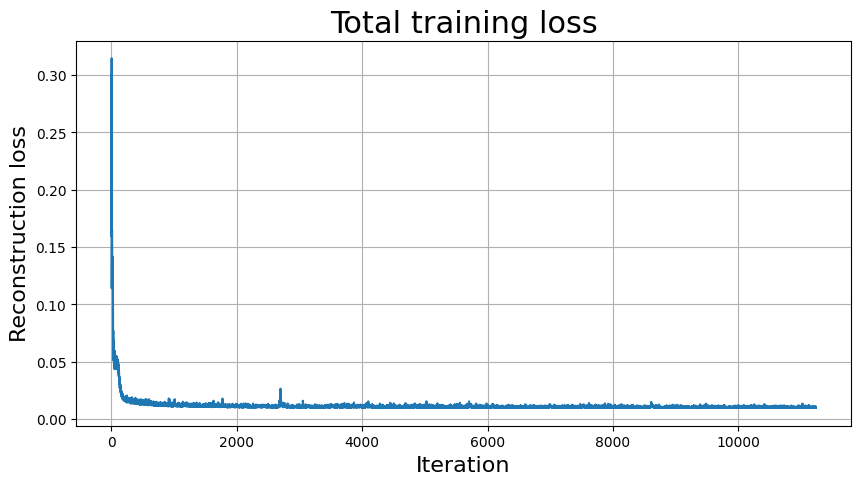

In [16]:
model = AutoEncoder() 
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
train_model(model, train_dataloader, optimizer, 15, device=device) 

In [32]:
# Print model's state_dict
with open('Model_state_dict.txt', 'w') as f:
    print("Model's state_dict:\n", file=f)    
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size(), file=f)

print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


# Print optimizer's state_dict
with open('Optimizer_state_dict.txt', 'w') as f:
    print("Optimizer's state_dict:\n", file=f)
    for var_name in optimizer.state_dict():
        print(var_name, "\t", optimizer.state_dict()[var_name], file=f)

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
encoder.conv1_watermark.weight 	 torch.Size([16, 1, 3, 3])
encoder.conv1_watermark.bias 	 torch.Size([16])
encoder.conv2_watermark.weight 	 torch.Size([16, 16, 3, 3])
encoder.conv2_watermark.bias 	 torch.Size([16])
encoder.conv3_watermark.weight 	 torch.Size([16, 16, 3, 3])
encoder.conv3_watermark.bias 	 torch.Size([16])
encoder.conv4_watermark.weight 	 torch.Size([16, 16, 3, 3])
encoder.conv4_watermark.bias 	 torch.Size([16])
encoder.conv5_watermark.weight 	 torch.Size([16, 16, 3, 3])
encoder.conv5_watermark.bias 	 torch.Size([16])
encoder.conv6_watermark.weight 	 torch.Size([16, 16, 3, 3])
encoder.conv6_watermark.bias 	 torch.Size([16])
encoder.conv7_watermark.weight 	 torch.Size([16, 16, 3, 3])
encoder.conv7_watermark.bias 	 torch.Size([16])
encoder.conv1_cover.weight 	 torch.Size([16, 3, 3, 3])
encoder.conv1_cover.bias 	 torch.Size([16])
encoder.conv2_cover.weight 	 torch.Size([16, 32, 3, 3])
encoder.conv2_cover.bias 	 torch.Size([16])
encoder.conv3_cover.weight

In [2]:
# Save:

PATH = 'savedmodel/model.pth'

torch.save(model.state_dict(), PATH)

NameError: name 'model' is not defined

In [8]:
# Load: ## Загрузить при запуске предобученной сети
PATH = 'savedmodel/model.pth'
net = AutoEncoder()
net.load_state_dict(torch.load(PATH))
net.eval()

AutoEncoder(
  (encoder): Encoder(
    (conv1_watermark): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_watermark): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_watermark): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_watermark): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_watermark): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6_watermark): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv7_watermark): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_cover): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_cover): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_cover): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_cover): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [12]:
# print(net)

In [10]:
def imgshow(img):
    npimg = np.array(img)
    plt.imshow(npimg)
    plt.show()

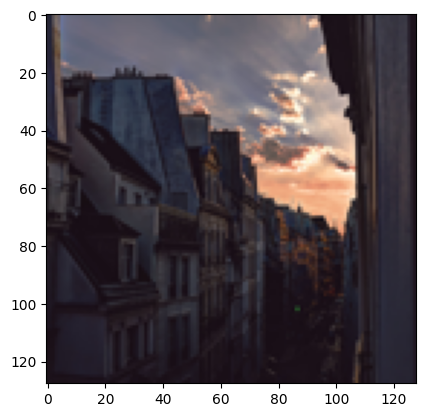

<class 'PIL.Image.Image'>


In [14]:
# cover_test = Image.open('PetImages/Cat/21.jpg').convert('RGB').resize((128,128))
cover_test = Image.open('saint.jpg').convert('RGB').resize((128,128))
imgshow(cover_test)
print(type(cover_test))

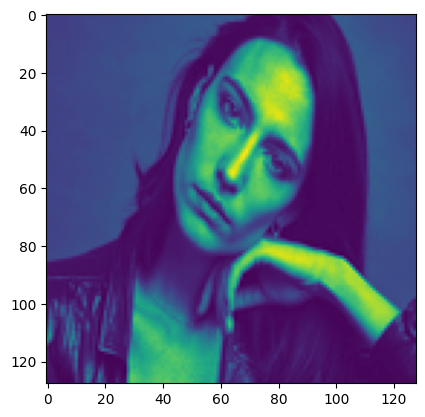

In [15]:
# logo_test = Image.open('PetImages/Dog/21.jpg').convert('L').resize((128,128))
logo_test = Image.open('wm.jpg').convert('L').resize((128,128))
imgshow(logo_test)

In [16]:
trans = transforms.Compose([transforms.ToTensor()]) 
cover_test = trans(cover_test)

In [17]:
logo_test = trans(logo_test)
test2 = net.encode(cover_test.unsqueeze(0), logo_test.unsqueeze(0), cover_test.unsqueeze(0))

In [18]:
# print(test2)

In [19]:
print(test2.shape)


torch.Size([1, 3, 128, 128])


In [20]:
imgtest2 = test2[0]
print(imgtest2.shape)

torch.Size([3, 128, 128])


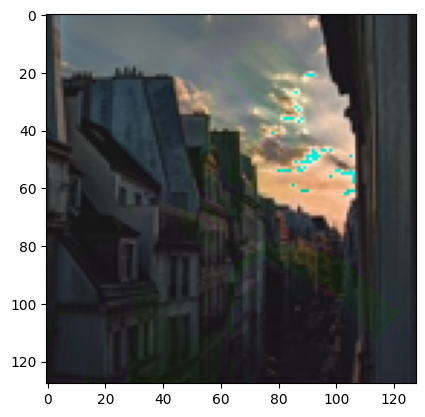

In [21]:
img = transforms.ToPILImage()(imgtest2)
imgshow(img)

In [22]:
print(type(img))

<class 'PIL.Image.Image'>


In [23]:
img.save("coverSaint-with-wm.jpg")
img.resize((1024,1024)).save("coverSaint-with-wm-resize.jpg")
width, height = img.size
print(f'width = {width}, height = {width}')
img = img.resize((1280,1024))
width, height = img.size
print(f'width = {width}, height = {width}')

width = 128, height = 128
width = 1280, height = 1280


In [25]:
img = trans(img)
print(img.shape)
test = net.discriminate(img.unsqueeze(0))
print(test.shape)

torch.Size([3, 1024, 1280])
torch.Size([80, 1])


In [26]:
test3 = net.decode(img.unsqueeze(0))
print(test3.shape)

torch.Size([1, 1, 1024, 1280])


In [27]:
imgtest3 = test3[0]
print(imgtest3.shape)

torch.Size([1, 1024, 1280])


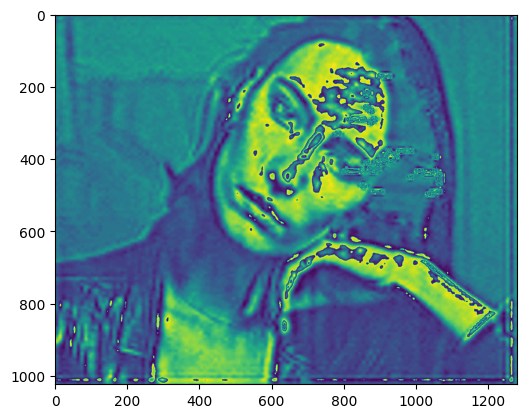

In [28]:
img3 = transforms.ToPILImage()(imgtest3)
imgshow(img3)

In [29]:
img3.save("resizecoverToOriginalSize-extract-wm.jpg")
img3.resize((1600,1200)).save("resizecoverToOriginalSize-extract-wm-resize.jpg")

In [31]:
# device = torch.device('cuda')
# print(device)
# net.to(device) # AssertionError: Torch not compiled with CUDA enabled

# print(torch.__version__)
# print(torch.cuda.is_available())

In [30]:
# a = torch.Tensor(5,3)
# print(a)
# print(a.cuda()) # AssertionError: Torch not compiled with CUDA enabled

In [9]:
testattack = Attack()

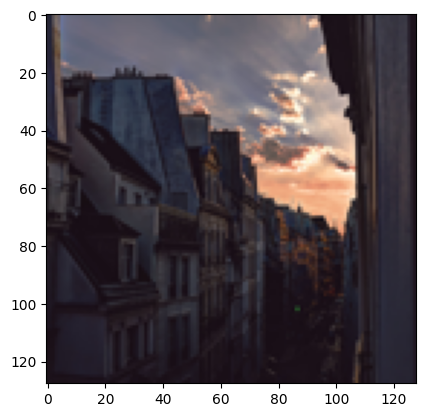

In [16]:
cover_test = Image.open('saint.jpg').convert('RGB').resize((128,128))
imgshow(cover_test)

In [17]:
trans = transforms.Compose([transforms.ToTensor()]) 
cover_test = trans(cover_test)
test2attack = testattack.salt(cover_test.unsqueeze(0))

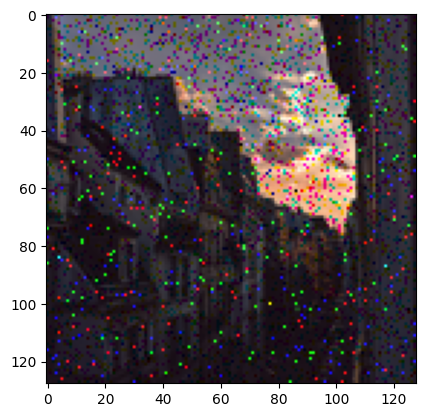

In [19]:
img4 = test2attack[0]
img4 = transforms.ToPILImage()(img4)
imgshow(img4)

In [20]:
img4.resize((1280,1024)).save("salt-and-peper-attack.jpg")

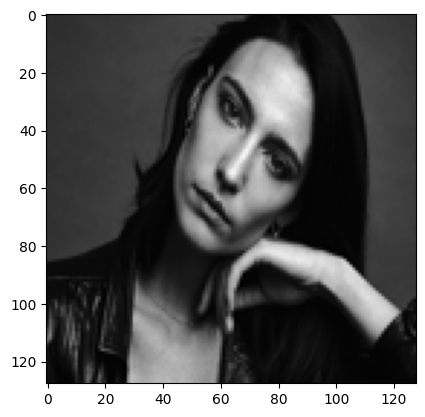

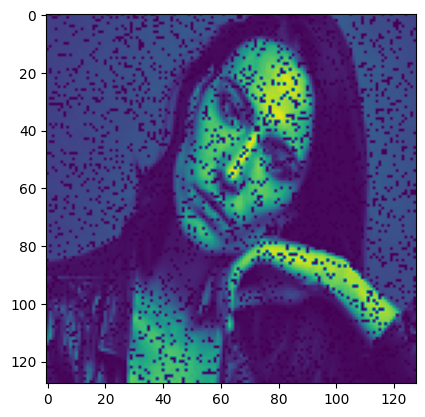

In [31]:
testattack = Attack()
cover_test = Image.open('wm.jpg').convert('RGB').resize((128,128))
imgshow(cover_test)
# trans = transforms.Compose([transforms.ToTensor()]) 
cover_test = trans(cover_test)

test2attack = testattack.dropout(cover_test)#.unsqueeze(0))

img4 = test2attack[0]
img4 = transforms.ToPILImage()(img4)
imgshow(img4)
img4.resize((1280,1024)).save("dropout-attack.jpg")